# PIT - Práctica 3: Detección de Actividad de Voz (VAD)

**Alicia Lozano Díez**

10 de marzo de 2025


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento de señales temporales de voz, y desarrollar de un detector de actividad de voz basado en redes neuronales recurrentes, en particular, LSTM.

### Materiales

- Guión (.ipynb) de la práctica - Moodle
- Ejemplos de datos y etiquetas - Moodle
- Listas de entrenamiento y validación - Moodle
- Scripts de descarga de datos - Moodle
- Datos y etiquetas de entrenamiento * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EeHT_NXP56FLkKffjyOhfa8BqAy3EmIrMkBZ0wnyDAti1g?download=1)
- Datos y etiquetas de validación * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/ESc5XzkpZ3ZBnGFQ6HWdn_UB38NHMOLTLtTcEE_b81Cylw?download=1)


**CUIDADO: Los datos proporcionados son de uso exclusivo para esta práctica. No tiene permiso para copiar, distribuir o utilizar el corpus para ningún otro propósito.**


# 1. Introducción al procesamiento de señales temporales de voz

## 1.1. Descarga de ficheros de ejemplo

Primero vamos a descargar el audio de ejemplo de Moodle (**audio_sample.wav**) y ejecutar las siguientes  líneas de código, que nos permitirán subir el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Una vez cargado el fichero de audio, podemos escucharlo de la siguiente manera:

In [1]:
import IPython

wav_file_name = "audio_sample.wav"
print(wav_file_name)
IPython.display.Audio(wav_file_name)

audio_sample.wav


## 1.2. Lectura y representación de audio en Python

A continuación vamos a definir ciertas funciones para poder hacer manejo de  ficheros de audio en Python.

Comenzamos definiendo una función **read_recording** que leerá un fichero de audio WAV, normalizará la amplitud y devolverá el vector de muestras _signal_ y su frecuencia de muestreo _fs_.

In [17]:
import scipy.io.wavfile

def read_recording(wav_file_name):
  fs, signal = scipy.io.wavfile.read(wav_file_name)
  signal = signal/max(abs(signal)) # normalizes amplitude

  return fs, signal


Si ejecutamos la función anterior para el fichero de ejemplo, podemos ver la forma en la que se carga dicho fichero de audio en Python. Así, podemos obtener la frecuencia de muestreo y la longitud del fichero en número de muestras:

In [18]:
fs, signal = read_recording(wav_file_name)
print("Signal variable shape: " + str(signal.shape))
print("Sample rate: " + str(fs))
print("File length: " + str(len(signal)) + " samples")


Signal variable shape: (67072,)
Sample rate: 16000
File length: 67072 samples


Para obtener la duración en segundos de la señal, tendríamos que usar la longitud en muestras y la frecuencia de muestreo:

In [19]:
# Duración en segundos
print("File length: " + str(len(signal)/fs) + " seconds")

File length: 4.192 seconds


También podemos representar la señal y ver su forma de onda. Para ello, definimos la función **plot_signal** como sigue:

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signal, fs, ylabel="", title=""):
  dur = len(signal)/fs
  step = 1./fs
  t_axis = np.arange(0., dur, step)

  plt.plot(t_axis, signal)
  plt.xlim([0, dur])
  plt.ylabel(ylabel)
  plt.xlabel('Time (seconds)')
  plt.title(title)
  plt.grid(True)


Y utilizando la función anterior, obtenemos su representación (amplitud frente al tiempo):

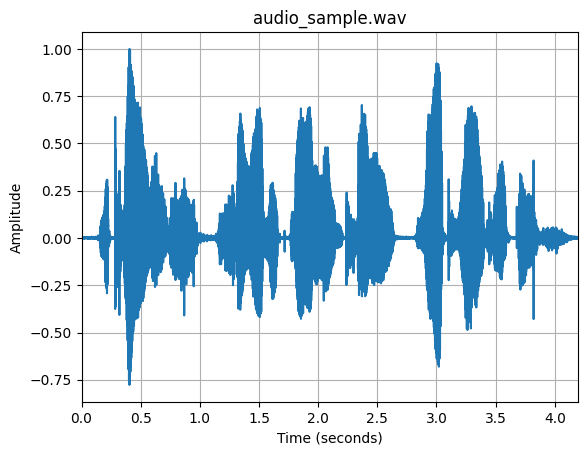

In [22]:
plot_signal(signal, fs, "Amplitude", wav_file_name)
plt.show()

## 1.3. Representación de etiquetas de actividad de voz

En esta práctica, vamos a desarrollar un detector de actividad de voz, que determinará qué segmentos de la señal de voz son realmente voz y cuáles silencio.

Por ello, vamos a ver dos ejemplos de etiquetas _ground truth_, que corresponden al fichero de audio de ejemplo.

Primero, descargamos de Moodle las etiquetas de voz/silencio que están en los ficheros **audio_sample_labels_1.voz** y **audio_sample_labels_2.voz** y las cargamos en Google Colab como en el caso anterior.

In [ ]:
from google.colab import files
uploaded = files.upload()

Estas etiquetas están guardadas en ficheros de texto y podemos cargarlas en Python de la siguiente manera:

In [23]:
labels_file_name = 'audio_sample_labels_1.voz'
voice_labels = np.loadtxt(labels_file_name)


Con el siguiente código, podemos representar la señal de voz así como sus etiquetas en la misma figura:

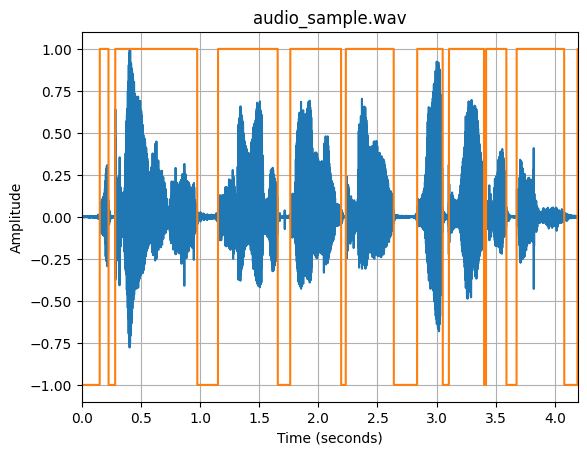

In [24]:
plot_signal(signal, fs)
# voice_labels*2-1 para transformar las etiquetas de 0 y 1 a -1 y 1
plot_signal(voice_labels*2-1, fs, "Amplitude", wav_file_name)
plt.show()

Las etiquetas de voz/silencio provienen de distintos detectores de actividad de voz.

**PREGUNTA 1: Represente la señal de voz junto con las etiquetas para ambos casos e incluya las figuras en el informe de la práctica. ¿Qué diferencias observas? ¿A qué se puede deber? ¿Qué cantidad de voz/silencio hay en cada etiquetado?**

## 1.4. Extracción de características

En la mayoría de sistemas de reconocimiento de patrones, un primer paso es la extracción de características. Esto consiste, a grandes rasgos, en obtener una representación de los datos de entrada, que serán utilizados para un posterior modelado.

En nuestro caso, vamos pasar de la señal en crudo _"raw"_ dada por las muestras (_signal_), a una secuencia de vectores de características que extraigan información a corto plazo de la misma y la representen. Esta sería la entrada a nuestro sistema de detección de voz basado en redes neuronales.

Para ver algunos ejemplos, vamos a utilizar la librería _librosa_ (https://librosa.org/doc/latest/index.html).

Dentro de esta librería, tenemos funciones para extraer distintos tipos de características de la señal de voz, como por ejemplo el espectrograma en escala Mel (_melspectrogram_).

Estas características a corto plazo, se extraen en ventanas de unos pocos milisegundos con o sin solapamiento.

Un ejemplo sería el siguiente:


In [26]:
import librosa

mel_spec = librosa.feature.melspectrogram(y=signal,sr=fs,n_mels=23,win_length=320,hop_length=160)

print(mel_spec.shape)
print(signal.shape)

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [27]:
!python -c "import numpy; print(numpy.__version__)"

1.26.4


**PREGUNTA 2: ¿Qué se obtiene de la función anterior? ¿Qué significan los valores de los parámetros _win_length_ y _hop_length_? ¿Qué significan las dimensiones de _mel_spec_?**

De esta manera, podríamos obtener una parametrización de las señales para ser utilizadas como entrada a nuestra red neuronal.

Para los siguientes apartados, se proporcionan los vectores de características MFCC para una serie de audios que se utilizarán como conjunto de entrenamiento del modelo de VAD.

#2. Detector de actividad de voz (Voice Activity Detector, VAD)



## 2.1. Descarga de los datos de entrenamiento

Primero vamos a descargar la lista de identificadores de los datos de entrenamiento de la práctica.

Para ello, necesitaremos descargar de Moodle el fichero **training_VAD.lst**, y ejecutar las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

A continuación cargamos los identificadores contenidos en el fichero en una lista en Python:

In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

Podemos ver algunos de ellos (los primeros 10 identificatores) de la siguiente forma:

In [ ]:
print(train_list[:10])

Ahora, descargaremos de Moodle el fichero **data_download_onedrive_training_VAD.sh**, y ejecutaremos las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Para descargar el conjunto de datos desde One drive, ejecutamos el script cargado anteriormente de la siguiente manera:

In [ ]:
!chmod 755 data_download_onedrive_training_VAD.sh
!./data_download_onedrive_training_VAD.sh

Este script descargará los datos de One Drive y los cargará en Google Colab, descomprimiéndolos en la carpeta **data/training_VAD**.

Podemos comprobar que los ficheros **.mat** se encuentran en el directorio esperado:


In [ ]:
!ls data/training_VAD/ | head

## 2.2. Definición del modelo

Utilizando la librería Pytorch (https://pytorch.org/docs/stable/index.html), vamos a definir un modelo de ejemplo con una capa LSTM y una capa de salida. La capa de salida estará formada por una única neurona. La salida indicará la probabilidad de voz/silencio utilizando una función *sigmoid*.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1, self).__init__()

        self.lstm = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=False)
        self.output = nn.Linear(256,1)

    def forward(self, x):

        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

Como se observa, los parámetros indicados serían los siguientes:

- Tamaño de la entrada a la capa LSTM: feat_dim
- Unidades (celdas) de la capa LSTM: 256
- Unidades de salida: 1 (capa lineal)

Además, la red LSTM espera un tensor de entrada con el tamaño del batch, la longitud de la secuencia así como la dimensionalidad del espacio de características. La función _forward_ permite obtener la predicción de la salida para un dato (o batch) de entrada (realiza el paso forward del modelo).

Revise la documentación de _torch.nn.LSTM_ y preste atención a los argumentos _batch_first_, _bidirectional_ y _dropout_.

**PREGUNTA 3: En este modelo, estamos utilizando una única neurona a la salida. ¿Hay alguna otra alternativa? ¿Se seguiría utilizando una función _sigmoid_?**


Una vez definida la clase, podemos crear nuestra instancia del modelo y cargarlo en la GPU con el siguiente código:

In [ ]:
model = Model_1(feat_dim=20)
model = model.to(torch.device("cuda"))
print(model)

Nuestra variable _model_ contiene el modelo, y ya estamos listos para entrenarlo y evaluarlo.

##2.3. Lectura y preparación de los datos para el entrenamiento

Como hemos visto anteriormente, nuestros datos están guardados en ficheros de Matlab (**.mat**). Cada uno de estos ficheros contiene una matriz **X** correspondiente a las secuencias de características MFCC (con sus derivadas de primer y segundo orden), y un vector **Y** con las etiquetas de voz/silencio correspondientes.

Veamos un ejemplo:


In [ ]:
features_file = 'data/training_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X']
labels = scipy.io.loadmat(features_file)['Y']

print(features.shape)
print(labels.shape)


Elija un fichero de entrenamiento y observe tanto el tamaño de **features** como de **labels**. Estas dimensiones se corresponden con la dimensionalidad de las características (20 coeficientes MFCC en nuestro caso) y la otra dimensión es la longitud de la secuencia en número de ventanas o frames.

El entrenamiento del modelo se va a realizar mediante descenso por gradiente (o alguna de sus variantes) basado en _batches_.

Para preparar cada uno de estos _batches_ que servirán de entrada a nuestro modelo LSTM, debemos almacenar las características en secuencias de la misma longitud. El siguiente código lee las características (**get_fea**) y sus correspondientes etiquetas (**get_lab**) de un fragmento aleatorio del fichero de entrada.

In [ ]:
import scipy.io
import numpy as np

def get_fea(segment, rand_idx):
    data = scipy.io.loadmat(segment)['X']
    if data.shape[0] <= length_segments:
        start_frame = 0
    else:
        start_frame = np.random.permutation(data.shape[0]-length_segments)[0]

    end_frame = np.min((start_frame + length_segments,data.shape[0]))
    rand_idx[segment] = start_frame
    feat = data[start_frame:end_frame,:]
    return feat[np.newaxis, :, :]


def get_lab(segment, rand_idx):
    data = scipy.io.loadmat(segment)['Y']
    start_frame = rand_idx[segment]
    end_frame = np.min((start_frame + length_segments, data.shape[0]))
    labs = data[start_frame:end_frame].flatten()
    return labs[np.newaxis,:]

**PREGUNTA 4: Analice las funciones anteriores detenidamente. ¿De qué tamaño son los fragmentos que se están leyendo? ¿Para qué sirve _rand_idx_?**

## 2.4. Entrenamiento del modelo
Una vez definidas las funciones de lectura de datos y preparación del formato que necesitamos para la entrada a la red LSTM, podemos utilizar el siguiente código para entrenarlo.

In [ ]:
length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

max_iters = 5
for epoch in range(1, max_iters):
  print('Epoch: ',epoch)
  model.train()
  cache_loss = 0

  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16)  for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label
    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))

    # Forward the data through the network
    outputs = model(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)

    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

  print("Loss: " + str(cache_loss/len(train_batch)))

Analice el código anterior cuidadosamente y preste atención a las siguientes cuestiones:

- ¿Qué función de coste se está optimizando?
- ¿Qué optimizador se ha definido?
- ¿Para qué se utiliza _batch_size_?
- ¿Cómo se crean los _batches_?
- ¿Qué línea de código realiza el _forward pass_?
- ¿Qué línea de código realiza el _backward pass_?

**PREGUNTA 5: ¿Cuántas iteraciones del algoritmo ha  realizado? ¿Qué observa en la evolución de la función de coste?**


A continuación, añada al código el cálculo de la precisión o _accuracy_, de tal manera que se muestre por pantalla dicho valor en cada iteración (similar a lo que ocurre con el valor del coste _loss_).

Observe si el valor de _accuracy_ es alto o bajo, y si hay margen de mejora.


## 2.5. Evaluación del modelo: un único fichero de test

Una vez entrenado el modelo, vamos a evaluarlo en un ejemplo en concreto.

Descargue de Moodle el fichero **audio_sample_test.wav**, con sus correspondientes características y etiquetas **audio_sample_test.mat** y evalúe el rendimiento en el mismo, observando por ejemplo el _accuracy_ obtenido.


In [ ]:
# Código de evaluación aquí


A continuación, represente 10 segundos de dicho audio, así como sus etiquetas de _ground_truth_ y las obtenidas con su modelo. Visualmente, ¿es bueno el modelo?

También puede escuchar el audio para evaluarlo cualitativamente.

In [ ]:
# Representación 10 segundos + etiquetas estimadas

## 2.6. Evaluación del modelo: conjunto de validación





Ahora vamos a evaluar el rendimiento del modelo anterior sobre un conjunto de validación (del que conocemos sus etiquetas).

Para este conjunto de datos, descargaremos la lista de identificadores **valid_VAD.lst** de Moodle, así como el fichero de descarga de datos **data_download_onedrive_valid_VAD.sh**:

In [ ]:
from google.colab import files
uploaded = files.upload()

!chmod 755 data_download_onedrive_valid_VAD.sh
!./data_download_onedrive_valid_VAD.sh

Escriba ahora el código necesario para evaluar el modelo anterior en el conjunto de datos de validación, para su última época.

Tenga en cuenta que si quiere realizar el forward para todos los datos de validación de una vez, necesitará que todas las secuencias sean de la misma longitud. Como aproximación, puede escoger unos pocos segundos de cada fichero como se hace en el entrenamiento.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

# 3. Comparación de modelos



## 3.1. Redes LSTM bidireccionales

En este apartado, vamos a partir del modelo inicial (_Model_1_) y modificarlo para que la capa LSTM sea bidireccional (_Model_1B_).

Entrene el nuevo modelo y compare el resultado con el modelo inicial.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

## 3.2. Modelo "más profundo"

En este apartado, vamos a partir nuevamente del modelo _Model_1_ y vamos a añadir una segunda capa LSTM tras la primera, con el mismo tamaño y configuración, definiendo un nuevo modelo _Model_2_.

Entrénelo y compare los resultados.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

**PREGUNTA 6: ¿Qué modelo obtiene un mejor resultado sobre los datos de validación, _Model_1_, _Model_1B_ o  _Model_2_? ¿Por qué puede ocurrir esto?**